In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import sys
import keras

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

## Loading MNIST Dataset

Loading Images for training

In [3]:
dir_path = os.getcwd()

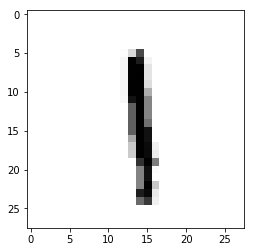

In [4]:
f = open(dir_path+'/train-images.idx3-ubyte')
loaded = np.fromfile(f,np.uint8)

trX = loaded[16:].reshape((60000,28,28)).astype(float)

plt.imshow(trX[8],cmap='Greys')

Loading labels for corrosponding image

In [5]:
f = open(dir_path+'/train-labels.idx1-ubyte')
loaded = np.fromfile(f,np.uint8)
trY = loaded[8:].reshape(60000).astype('uint8')
trY[8]

1

## Generator

Generator part of GANs

This needs to take noise as input and generate Image samples as output

In [ ]:
def generator2(X_inputs):
    
    X_inputs = tf.keras.layers.Flatten()
    print(X_inputs)
    #dense layer
    X1 = tf.layers.dense(X_inputs,units=128)
    print(X1)
    X2 = tf.nn.relu(X1)
    #output layer
    print(X2)
    X3 = tf.layers.dense(X2,units=784,activation='tanh') #error : 'str' object is not callable
    X = tf.reshape(X3,(28,28,1))
    return X

In [8]:
def generator(X_input):
    
    # Hidden layer with leaky relu
    X = Dense(units=128,name = 'Gen_Dense1')(X_input)
    X = LeakyReLU()(X)
    X = Dense(units=128,name = 'Gen_Dense1.1')(X)
    X = LeakyReLU()(X)

    # Output Layer
    X = Dense(units = 28*28,activation='relu',name = 'Gen_Dense2')(X)
    
    # Reshape output layer to the size of image 
    X = Reshape(target_shape=(28,28))(X)
    return X
    

Let's Test the Above function by and check the vale

(2, 28, 28)
<type 'numpy.ndarray'>


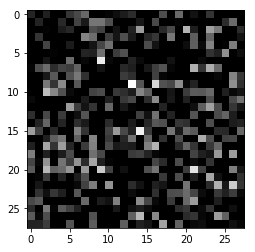

In [9]:
tf.reset_default_graph()
with tf.Session() as test:
    
    X1 = np.random.rand(2,100)
    X_i = tf.placeholder("float",shape=[None,100])
    los = generator(X_i)
    test.run(tf.global_variables_initializer())
    feed_dic = {
        X_i : X1
    }
    out = test.run(los,feed_dict=feed_dic)
    print(out.shape)
    print(type(out))
    plt.imshow(out[0],cmap='gray')


## Discriminator

This should Take 28x28 image as input and predict whether the data was fake or real

In [10]:
def Discriminator(X_input):
    
    # Flatten the image to pass it through nn
    X = Flatten()(X_input)
    
    # Hidden Layer
    X = Dense(units=128)(X)
    X = LeakyReLU(alpha=.01)(X)
    
    #Output Layer to predict fake or real
    X = Dense(units=1,activation='sigmoid')(X)
    return X
    

snippet to test above code

In [11]:
tf.reset_default_graph()
with tf.Session() as test:
    
    X1 = np.random.rand(1,28,28)
    X_i = tf.placeholder("float",shape=[None,28,28])
    los = Discriminator(X_i)
    test.run(tf.global_variables_initializer())
    feed_dic = {
        X_i : X1
    }
    out = test.run(los,feed_dict=feed_dic)
    print(out.shape)
    print(type(out))


(1, 1)
<type 'numpy.ndarray'>


In [12]:
def Discrimantor_model(X_input_shape = (28,28)):
    X_input = Input(X_input_shape)
    X = Discriminator(X_input)
    model = Model(X_input,X,name = 'discriminator')
    return model

In [13]:
def Generator(X_input_shape = 100):
    X_input = Input(shape=(X_input_shape,))
    X = generator(X_input)
    model = Model(X_input,X,name = 'Generator')
    return model

## Build the Model

    D_loss = sum(log(D)+log(1-D_G))
=>  D_loss = (x.log(D)) + (1-x)(log(1-D_G))

where x = 1 when images are real and 0 when images are fake
This is inturn Binary Entropy

This below is all models required to train 
We are using 2 Models.

1. Discrimanator:
   This is a simple NN so it will take img as i/p and try to predict real/fake as output
   
   
2. Combined (generator image passed by Discrimanator): 
   This takes passes Generated Image as input to Discrimator. It should always o/p 1 as Discrimanator o/p should be predicted as real 


## Train and execute

In [14]:
def gen_loss(y_true,y_pred):
    loss = tf.log((y_true-y_pred))
    return loss

In [15]:
batch_size = 100

# Discrimanator
dis_model = Discrimantor_model()
dis_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Build the Generator
gen_model = Generator()

# Generated image to be used as input
z = Input(shape=(100,))
fake_img = gen_model(z)

# No change in dis while Discrimantor is chaned
dis_model.trainable= False

pred = dis_model(fake_img)  # D(G(z))

combined_model = Model(z,pred)  
combined_model.compile(optimizer='adam',loss=gen_loss)

# loss_d = tf.reduce_sum(tf.log(D)+tf.log(1-D_G))  # loss by discrimanator
# loss_g = tf.log(1-D_G)                           # loss by generator



In [15]:
def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, 
              (image_grid_rows * image_grid_columns, 100))

    # Generate images from random noise 
    gen_imgs = gen_model.predict(z)

    # Rescale images to 0-1
    gen_imgs = 0.5 * gen_imgs + 0.5

    
    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                    figsize=(4,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output image grid
            axs[i,j].imshow(gen_imgs[cnt, :,:], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.savefig('Results/iter'+str(iteration)+'.png')


Adding noise should help according to some sources

In [17]:
iterations = 500
losses = []
Accuracy = []
save_iter = 100
# Normalize Training Set
trX = trX/127.5 - 1

# Labels for real and fake examples
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for i in range(iterations):
        
        #  Train the Discriminator
        # This is a simple NN so it will take img as i/p and try to predict real/fake as output

        # Select a random batch of real images
        idx = np.random.randint(0, trX.shape[0], batch_size)
        real_imgs = trX[idx]+ np.random.normal(0,0.1,trX[idx].shape)


        # Generate a batch of fake images
        z = np.random.rand(batch_size, 100)
        fake_imgs = gen_model.predict(z)
        
        # Discriminator loss
        d_loss_real = dis_model.train_on_batch(real_imgs, real)
        d_loss_fake = dis_model.train_on_batch(fake_imgs, fake)
        
        # Summing over all losses and divinging by batch size i.e avg them
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        
        #  Train the Generator
        # we want Discrimator prediction to be real always so expected output would be 1
        # and input is some random variable X to make images

    
        # Generate a batch of fake images
        z = np.random.rand(batch_size, 100)
        gen_imgs = gen_model.predict(z)

        # Generator loss - where model failed to fool fake_img as real by Dis  
        g_loss = combined_model.train_on_batch(z, real)


        if i % save_iter == 0:
            
            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (i, d_loss[0], 100*d_loss[1], g_loss))
            
            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            Accuracy.append(100*d_loss[1])

            # Output generated image samples 
            sample_images(i)
        

## Alternate way

Trying a different way with the cost function said in the paper

0 [D loss: -inf] [G loss: -1.012513]
100 [D loss: -1.305150] [G loss: -1.005117]
200 [D loss: -inf] [G loss: -0.993086]
300 [D loss: -5.314338] [G loss: -1.009543]
400 [D loss: -4.415679] [G loss: -1.003736]
500 [D loss: -3.528258] [G loss: -1.007100]
600 [D loss: -2.784455] [G loss: -0.997856]
700 [D loss: -6.266065] [G loss: -1.006130]
800 [D loss: -2.262588] [G loss: -1.009227]
900 [D loss: -inf] [G loss: -1.004827]


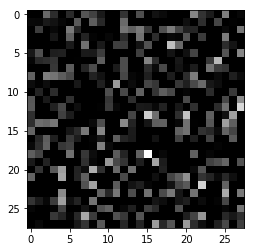

In [14]:
iterations = 1000
save_iter = 100
batch_size = 100

tf.reset_default_graph()

dis_in = tf.placeholder("float",shape=[None,28,28])
gen_in = tf.placeholder("float",shape=[None,100])

pred_fake = Discriminator(generator(gen_in))+0.000000001 # D(G(z))
pred_real = Discriminator(dis_in+0.00000001) # D(x)

# define the loss functions
loss_d = tf.reduce_sum(tf.log(pred_real) + tf.log(1 - pred_fake))/batch_size
loss_g = tf.reduce_sum(tf.log(1 - pred_fake))/batch_size


# training steps
optimizer = tf.train.AdamOptimizer()
train_step_d = optimizer.minimize(loss_d)
train_step_g = optimizer.minimize(loss_g)

# train the model
loss_d_list = []
loss_g_list = []


for i in range(iterations):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # Select a random batch of real images
    idx = np.random.randint(0, trX.shape[0], batch_size)
    real_imgs = trX[idx]+ np.random.normal(0,0.1,trX[idx].shape)

    z = np.random.normal(0,1,(batch_size,100))
    # train discriminator
    sess.run(tf.global_variables_initializer())
    feed_dict_d = {gen_in: z
        ,dis_in : real_imgs}
    _, l_d = sess.run([train_step_d, loss_d], feed_dict = feed_dict_d)
    loss_d_list.append(l_d)
    
    # train generator
    z = np.random.rand(batch_size, 100)
    feed_dict_g = {gen_in:z
                  ,dis_in:real_imgs}
    _, l_g = sess.run([train_step_g, loss_g], feed_dict = feed_dict_g)
    loss_g_list.append(l_g)
    
    if i % save_iter == 0:

        # Output training progress
        print ("%d [D loss: %f] [G loss: %f]" % 
                     (i, l_d,l_g))
        
        # Output generated image samples

        ig = generator(gen_in)
        feed_g = {gen_in:z}
        sess.run(tf.global_variables_initializer())
        img = sess.run(ig,feed_dict = feed_g)
        
        plt.imshow(img[0],cmap='gray')
        plt.savefig('Results/Gans-1/it_'+str(i)+'.png')
        


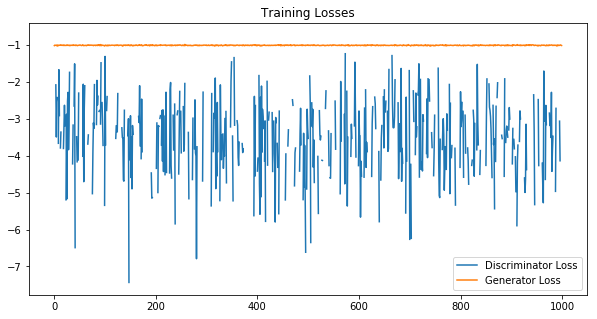

In [15]:
loss_d = np.array(loss_d_list)
loss_g = np.array(loss_g_list)
# Plot training losses for Discriminator and Generator
plt.figure(figsize=(10,5))
plt.plot(loss_d, label="Discriminator Loss")
plt.plot(loss_g, label="Generator Loss")
plt.title("Training Losses")
plt.legend()


##  Conclusion

Both the ways fail here (I have tried with more than 3000 iterations on collab GPU but No improvement could be seen) . Let's try different Architecture